In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('grayscale')
plt.rc("figure", figsize=(16, 5))

def read_dataset(folder, file, date_col=None, format=None, index=False):
    '''Reads a CSV dataset and converts date columns to datetime.'''
    index_col = date_col if index else None
    df = pd.read_csv(folder / file, 
                     index_col=index_col, 
                     parse_dates=[date_col],
                     date_format=format)
    return df

def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''Creates comparative plots of original vs. missing data.
	    hint: df1 is the original dataset, while df2 contains your DataFrame
	    with different imputation strategies
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    fig, ax = plt.subplots(subplots_size + 1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    
    if title:
        fig.suptitle(title)
    
    df1[col].plot(ax=ax[0], figsize=(12, 10))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i + 1])
        ax[i + 1].set_title(colname)
    
    fig.tight_layout()
    plt.show()

def rmse_score(df1, df2, col=None):
    '''Calculates RMSE scores between original and processed data.'''
    if col is None:
        raise ValueError("Column name must be specified")
        
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    
    if len(columns) <= 1:
        raise ValueError("No comparison columns found")
    
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    
    return scores

In [24]:
from pathlib import Path 

folder = Path('./')
co2_original = read_dataset(folder, 'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date', index=True)

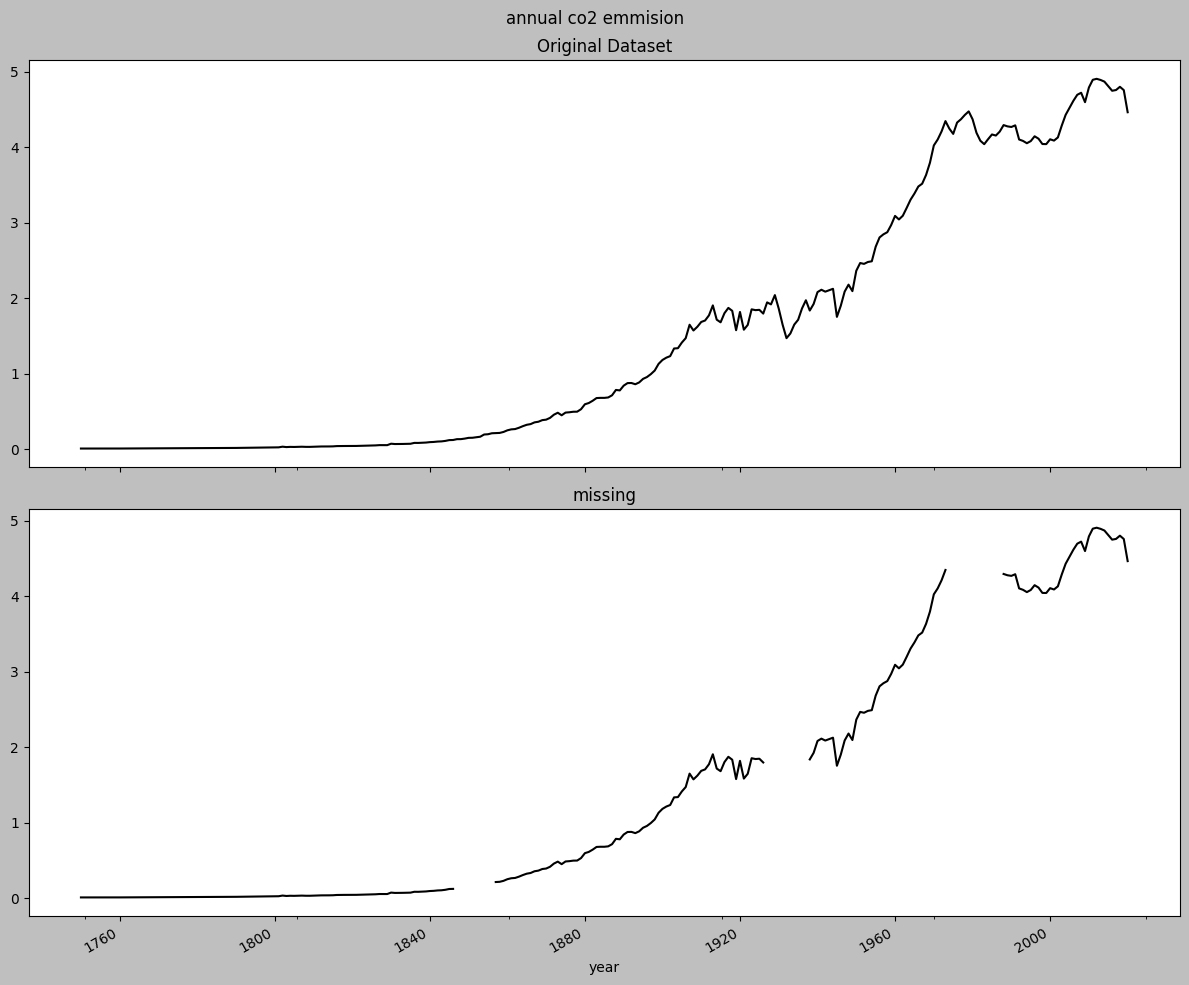

In [8]:
plot_dfs(
    co2_original,
    co2_missing,
    'co2',
    title="annual co2 emmision"

)

In [9]:
co2_missing.isna().sum()

co2    35
dtype: int64

In [10]:
co2_missing.head()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206


In [11]:
average = co2_missing['co2'].mean()
median = co2_missing['co2'].median()

In [17]:
co2_missing['ffil'] = co2_missing['co2'].ffill()
co2_missing['bfil'] = co2_missing['co2'].bfill()
co2_missing['mean'] = co2_missing['co2'].fillna(average) 
co2_missing['0'] = co2_missing['co2'].fillna(0) 
co2_missing['median'] = co2_missing['co2'].fillna(median) 


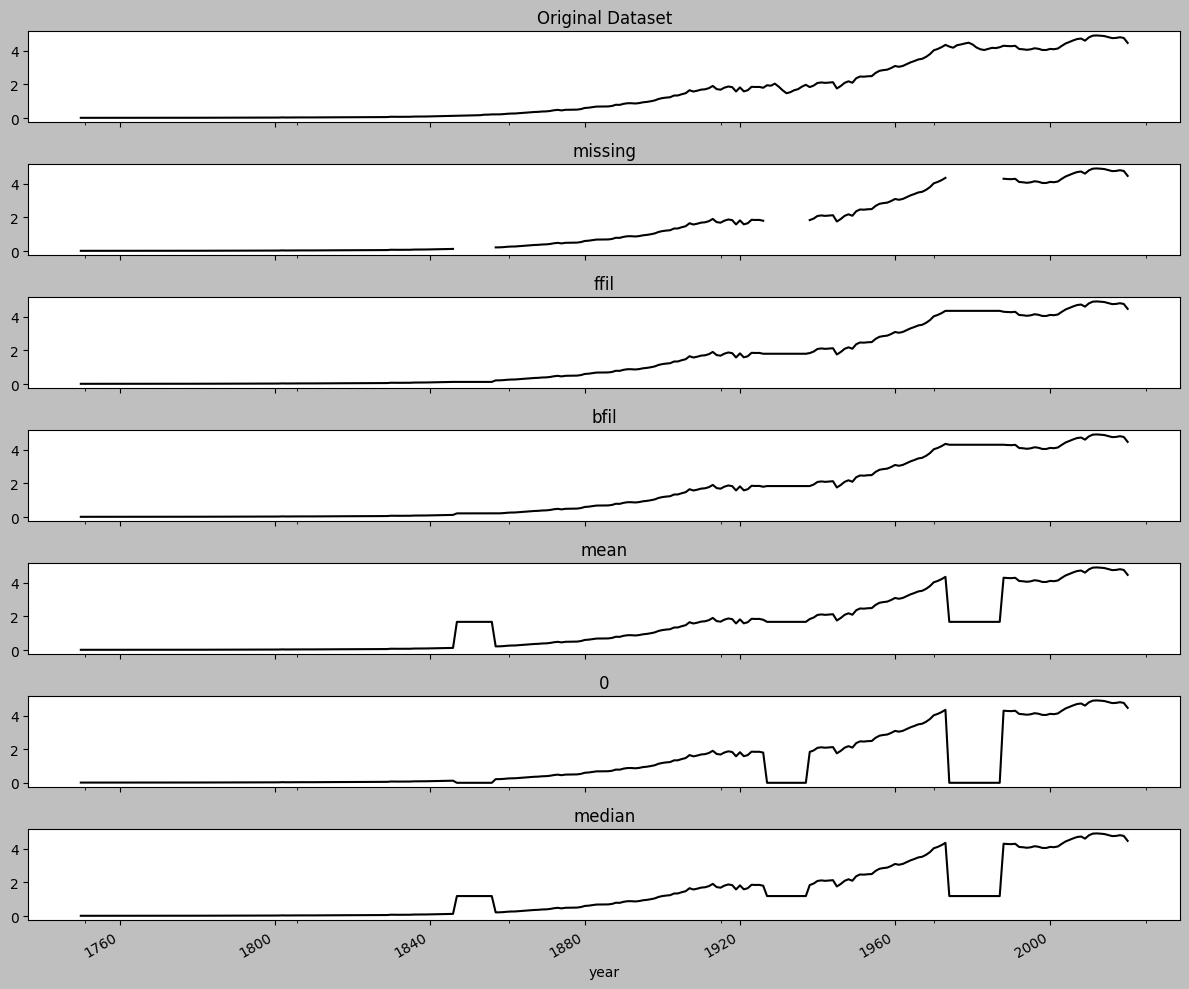

In [18]:
plot_dfs(
    co2_original,
    co2_missing,
    'co2'
)

In [19]:
co2_missing.head()

,co2,ffil,bfil,mean,0,median
year,,,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206,0.0206,0.0206


In [20]:
score = rmse_score(co2_original,
                    co2_missing,
                    'co2')

RMSE for ffil: 0.05873012599267133
RMSE for bfil: 0.05550012995280968
RMSE for mean: 0.7156383637041684
RMSE for 0: 1.1285178854727376
RMSE for median: 0.802942160685986


In [23]:
print(type(score))

<class 'list'>


In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import (ElasticNet, 
                                  LinearRegression, 
                                  BayesianRidge)
from sklearn.neighbors import KNeighborsRegressor

In [28]:
from sklearn.impute import SimpleImputer

In [29]:
mean_imputer = SimpleImputer(strategy='mean')

In [35]:
co2_vals = co2_missing['co2'].values.reshape(-1, 1)

In [37]:
co2_missing['mean'] = mean_imputer.fit_transform(co2_vals)
co2_missing

,co2,mean
year,,
1750-01-01,0.0125,0.0125
1760-01-01,0.0128,0.0128
1770-01-01,0.0150,0.0150
1780-01-01,0.0169,0.0169
1790-01-01,0.0206,0.0206
...,...,...
2016-01-01,4.7496,4.7496
2017-01-01,4.7595,4.7595
2018-01-01,4.8022,4.8022


<Axes: xlabel='year'>

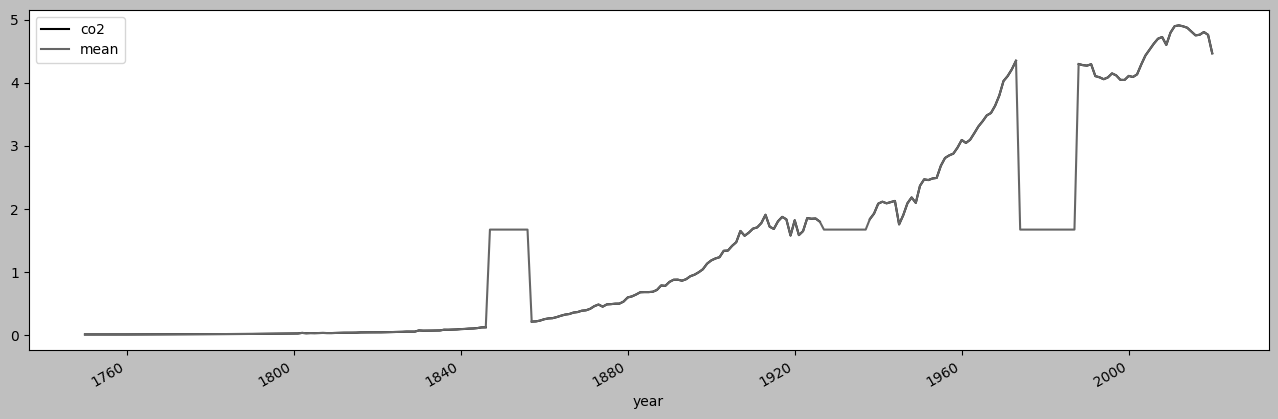

In [39]:
co2_missing.plot()

In [43]:
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
co2_missing['most_frequent'] = most_frequent_imputer.fit_transform(co2_vals)
co2_missing

,co2,mean,most_frequent
year,,,
1750-01-01,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206
...,...,...,...
2016-01-01,4.7496,4.7496,4.7496
2017-01-01,4.7595,4.7595,4.7595
2018-01-01,4.8022,4.8022,4.8022


In [44]:
clicks_missing

,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784.0
2008-04-02,43.079056,1,24738.0
2008-04-03,43.842609,2,15209.0
2008-04-04,43.312376,1,14018.0
2008-04-05,43.941176,1,11974.0
...,...,...,...
2008-08-09,44.182033,1,6716.0
2008-08-10,43.608260,1,9523.0
2008-08-11,43.553363,1,8881.0


In [46]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [47]:
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import (ElasticNet, 
                                  LinearRegression, 
                                  BayesianRidge)
from sklearn.neighbors import KNeighborsRegressor

In [48]:
regressors = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=50, random_state=42)),
    ('bagging', BaggingRegressor(n_estimators=50, random_state=42)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]

In [52]:
clicks_val = clicks_missing['clicks'].to_numpy().reshape(-1, 1)

In [58]:
clicks_val = clicks_missing.iloc[:, 0:3].to_numpy()

In [62]:
for regression_name, reg_model in regressors:
    estimate = IterativeImputer(random_state=42,
                                estimator=reg_model)
    estimate.fit(clicks_val)
    clicks_missing[regression_name] = estimate.transform(clicks_val)[:, 2]


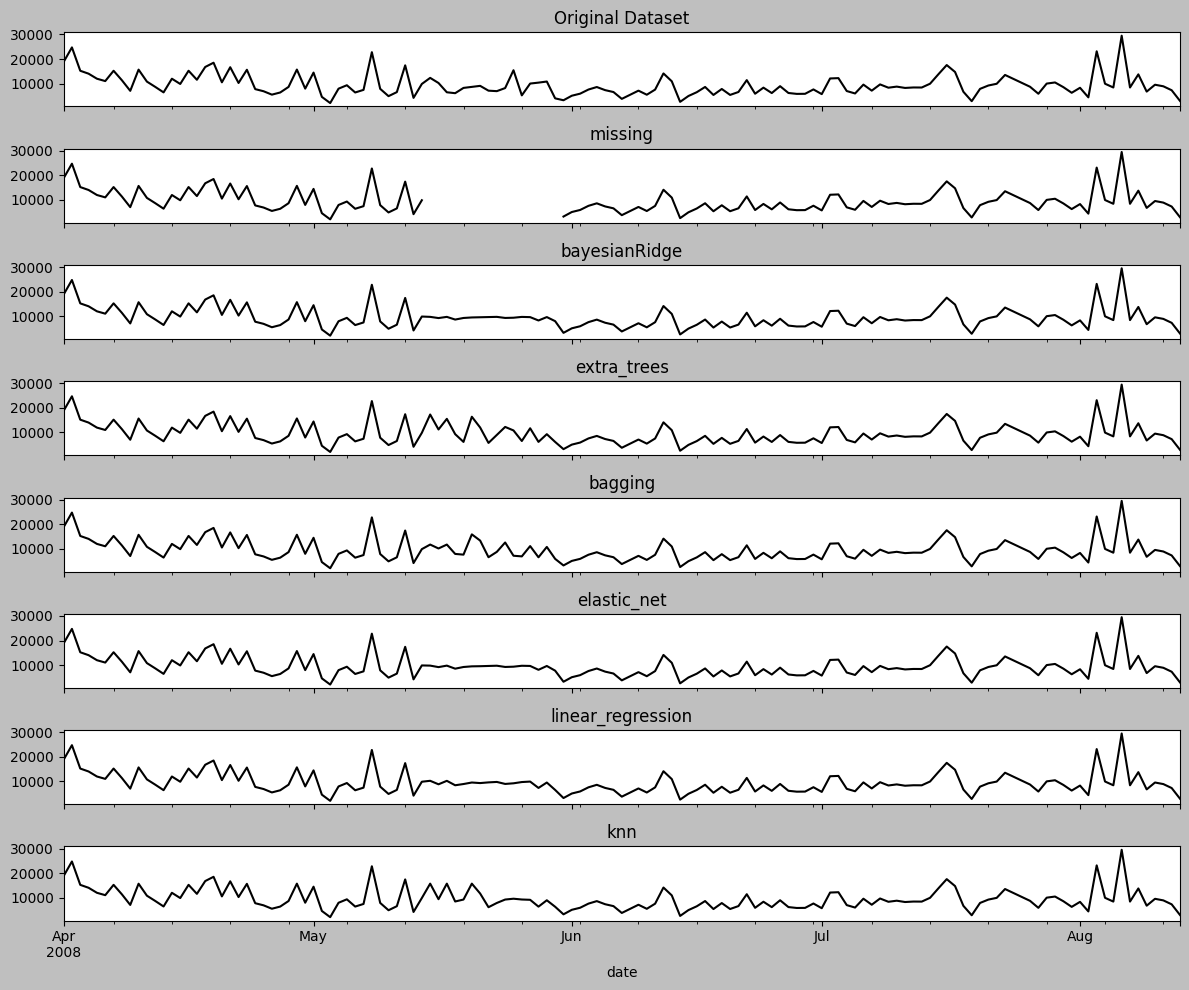

In [63]:
plot_dfs(clicks_original,
        clicks_missing,
        'clicks')

In [64]:
rmse_score(
    clicks_original,
    clicks_missing,
    'clicks'
)

RMSE for bayesianRidge: 949.439397345585
RMSE for extra_trees: 1404.1501333341182
RMSE for bagging: 1265.5100992417892
RMSE for elastic_net: 945.40752093431
RMSE for linear_regression: 938.9419831427184
RMSE for knn: 1336.8798392251822


[np.float64(949.439397345585),
 np.float64(1404.1501333341182),
 np.float64(1265.5100992417892),
 np.float64(945.40752093431),
 np.float64(938.9419831427184),
 np.float64(1336.8798392251822)]

In [65]:
co2_original = read_dataset(folder, 'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date', index=True)

In [66]:
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

In [67]:
for inter in interpolations:
    co2_missing[inter] = co2_missing['co2'].interpolate(method=inter)

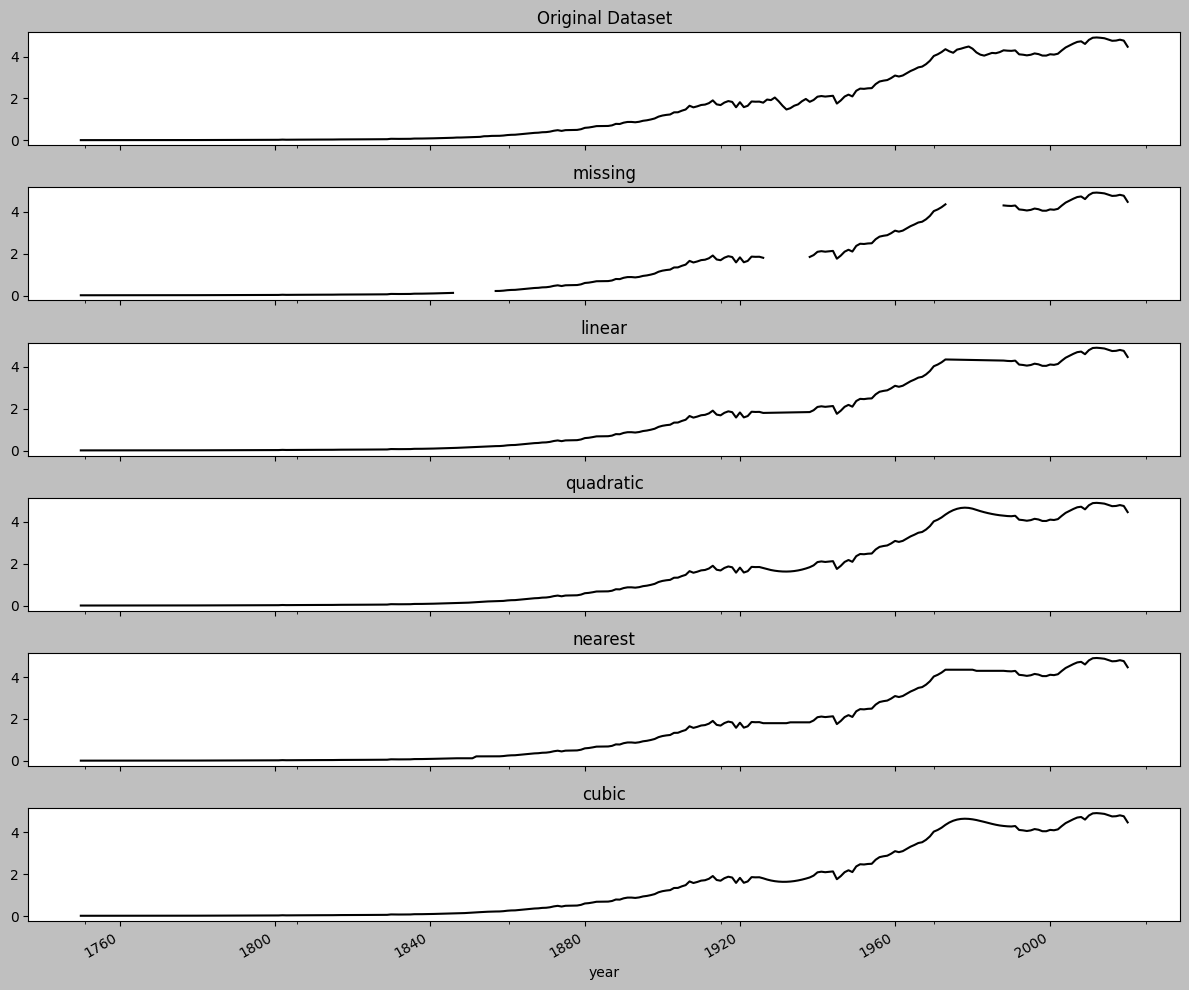

In [68]:
plot_dfs(
    co2_original,
    co2_missing,
    'co2'
)

In [69]:
rmse_score(
    co2_original,
    co2_missing,
    'co2'
)

RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614346
RMSE for nearest: 0.05385422309469095
RMSE for cubic: 0.08373627305833138


[np.float64(0.05507291327761665),
 np.float64(0.08367561505614346),
 np.float64(0.05385422309469095),
 np.float64(0.08373627305833138)]

In [70]:
for inter in interpolations:
    clicks_missing[inter] = clicks_missing['clicks'].interpolate(method=inter)

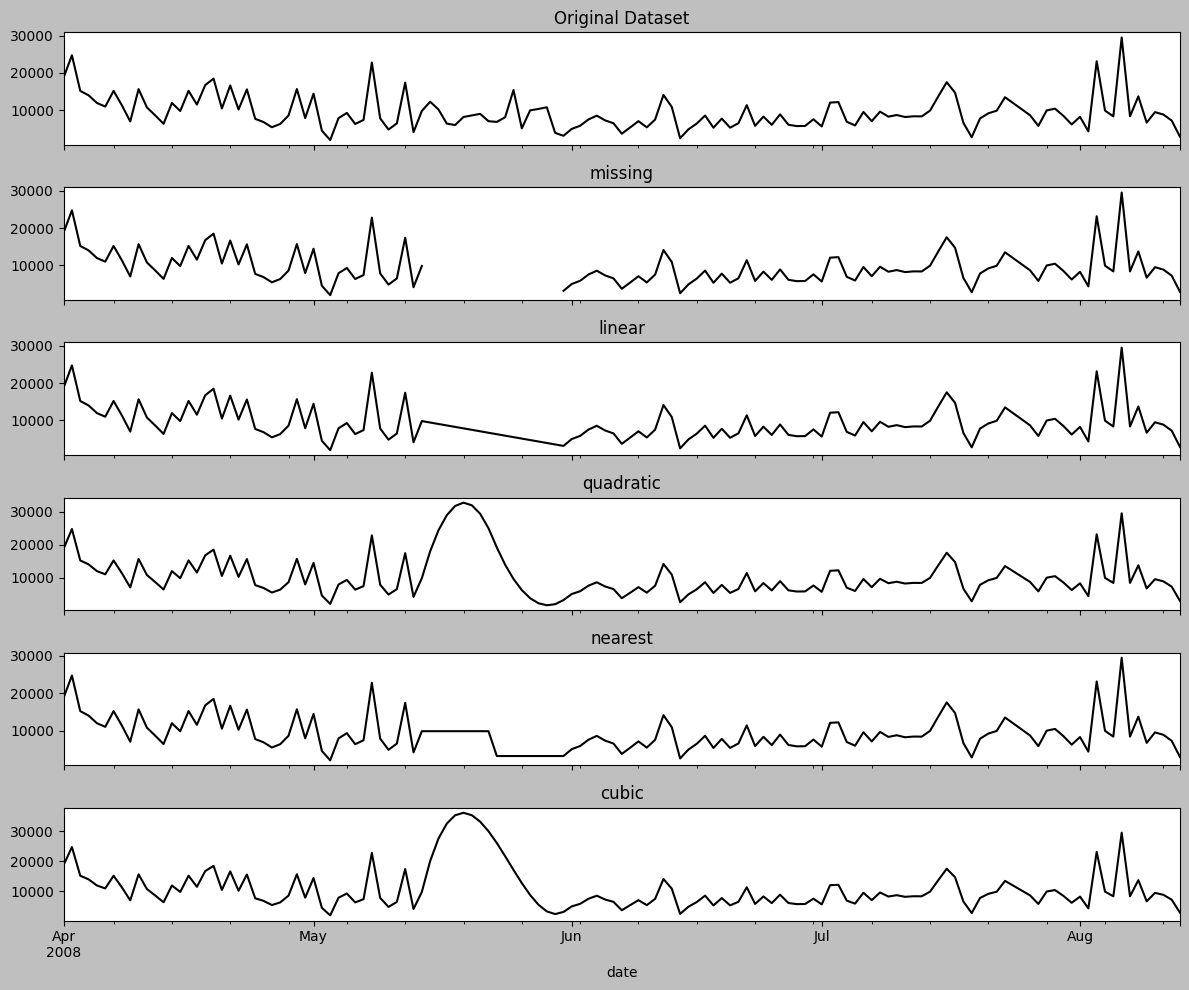

In [71]:
plot_dfs(
    clicks_original,
    clicks_missing,
    'clicks'
)

In [72]:
rmse_score(
    clicks_original,
    clicks_missing,
    'clicks'
)

RMSE for linear: 1329.1448378562811
RMSE for quadratic: 5224.641260626974
RMSE for nearest: 1706.1853705030173
RMSE for cubic: 6199.304875782833


[np.float64(1329.1448378562811),
 np.float64(5224.641260626974),
 np.float64(1706.1853705030173),
 np.float64(6199.304875782833)]